## Image Colorization with deep convolutional Neural Network

First of all this notebook would be very useful for the beginners to understand how black and white images could be colorized using Convolution Neural Network. <br>

The latest neural network technique involves the use of Resnet for feature extraction and combines or fusing it with a layer that comes after pooling/downsampling of the input or encoded layer and then decoding it with convolution layers through upsampling to predict the colored image. Also, there are various types of GAN such as pix2pix GAN, Cycle gan which are much more advanced techniques for image colorization.<br>

The auto-encoder network which I have explained in this model also servers the purpose of a generator in the GAN network. There understanding this notebook would help you further in understanding complex networks and methodologies involved in image colorization.<br>

## The objective
The objective of this notebook is to serve as an experimental purpose for how the most basic auto-encoder would perform against image colorization. This auto-encoder model is implemented with higher-level or complicated methodologies to solve image colorization with excellent results. But how will the most basic auto-encoder perform to solve this problem is demonstrated here.

What I have done here is very basic implementation of the colorizing model after going through a variety of research papers and website refrences. hope this would be very helpful....

Link for references: [https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d)

[https://www.learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/](https://www.learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/)

There are also various other techniques you could follow to colorize black and white images with deep learning

### Most Basic Colorizing neural network model
![Most Basic Colorizing neural network model](http://richzhang.github.io/colorization/resources/images/net_diagram.jpg)
### Colorization using Interception-resnet layer in parallel
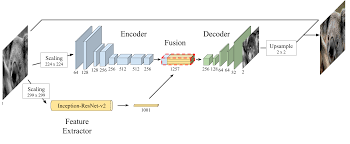

# Tiny ImageNet dataset


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow import set_random_seed
import tensorflow as tf
import glob
from pathlib import Path
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.image import decode_jpeg
set_random_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
set_random_seed(2)
np.random.seed(1)

HEIGHT = 32
WIDTH = 32


Using TensorFlow backend.


In [2]:
ImagePath = "../input/tiny-imagenet/tiny-imagenet-200/train/"

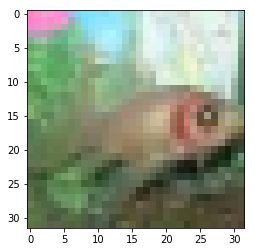

In [3]:
img = cv2.imread("../input/tiny-imagenet/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (HEIGHT, WIDTH))
plt.imshow(img)

**There are two techniques to generate colored image from its gray scaled form:-**
1. **Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value**.
2. **Turn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value**.

Here I have used Lab value to colorize the image, where  L stands for lightness, and a and b for the color spectra green–red and blue–yellow.**

## NOTE:-

* Our Dataset consists of all coloured images and we have to use black and white image for training the model therefore we would be converting the colored image to grayScaled image and then turning it to RGB format to get the complete black and white image conversion.
* I have also used Opencv to read the image but Opencv reads the image in BGR format, so we need to convert the image to RGB format first before turning it to greyscale.
* You could also avoid using Opencv.
* There are many lines of code which you would to be see in traditional colorizing technique but I have commented out those for better results in my case and also I have explained the reason with comments why that part of the code is used in traditional Colorizing technique.

In [4]:
def ExtractInput(path):
    X_img=[]
    y_img=[]
    files = path
    
    for file in files:
        file = str(file)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = img.astype(np.float32)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
        img_l = img_lab_rs[:,:,0]
        img_ab = img_lab_rs[:,:,1:]
        img_ab = img_ab/128
        X_img.append(img_l)
        y_img.append(img_ab)

    X_img = np.array(X_img)
    y_img = np.array(y_img)
    print("X_img shape : ", X_img.shape)
    print("y_img shape : ", y_img.shape)
    return X_img,y_img


In [5]:
path = Path(ImagePath).glob('*/images/*')
X_,y_ = ExtractInput(path)

X_img shape :  (100000, 32, 32)
y_img shape :  (100000, 32, 32, 2)


In [6]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
#     model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [86]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [87]:
LEARNING_RATE = 0.000001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 32, 32, 16)   160         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 32, 32, 16)   0           conv2d_46[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 32, 32, 32)   4640        leaky_re_lu_41[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [88]:

custom_early_stopping = EarlyStopping(
    monitor='loss', 
    patience=5, 
    mode='auto',
    min_delta=0.00001
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=5, 
    min_lr=0.00001,
    verbose=2
)

def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,HEIGHT,WIDTH,1)
        y_input = y_[i].reshape(1,HEIGHT,WIDTH,2)
        yield (X_input,y_input)

In [89]:
Model_Colourization.fit_generator(GenerateInputs(X_,y_), callbacks=[custom_early_stopping, reduce_lr],epochs=100,verbose=1,steps_per_epoch=512,shuffle=True)

Epoch 1/100
512/512 [==============================] - 9s 17ms/step - loss: 0.1724
Epoch 2/100
512/512 [==============================] - 6s 12ms/step - loss: 0.0995
Epoch 3/100
512/512 [==============================] - 6s 11ms/step - loss: 0.0798
Epoch 4/100
512/512 [==============================] - 7s 13ms/step - loss: 0.0667
Epoch 5/100
512/512 [==============================] - 6s 11ms/step - loss: 0.0577
Epoch 6/100
512/512 [==============================] - 6s 12ms/step - loss: 0.0617
Epoch 7/100
512/512 [==============================] - 6s 11ms/step - loss: 0.0651
Epoch 8/100
512/512 [==============================] - 6s 12ms/step - loss: 0.0540
Epoch 9/100
512/512 [==============================] - 7s 13ms/step - loss: 0.0551
Epoch 10/100
512/512 [==============================] - 6s 12ms/step - loss: 0.0578
Epoch 11/100
512/512 [==============================] - 6s 12ms/step - loss: 0.0655
Epoch 12/100
512/512 [==============================] - 6s 11ms/step - loss: 0.0526
E

In [90]:
TestImagePath="../input/tiny-imagenet/tiny-imagenet-200/test/images/"

In [91]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,WIDTH,HEIGHT,1)
    
    return img_l_reshaped

In [92]:
# psnr function from github
# https://github.com/XiaoCode-er/python-PSNR/blob/master/psnr.py
# for psnr, the higher the better

import numpy
from skimage import io
import tensorflow as tf

def log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def psnr(im1, im2):
    img_arr1 = numpy.array(im1).astype('float32')
    img_arr2 = numpy.array(im2).astype('float32')
    mse = tf.reduce_mean(tf.squared_difference(img_arr1, img_arr2))
    psnr = tf.constant(255**2, dtype=tf.float32)/mse
    result = tf.constant(10, dtype=tf.float32)*log10(psnr)
    with tf.Session():
        result = result.eval()
    return result

In [93]:
# ssim function from github
# https://github.com/Momom52/tensorflow-ssim/blob/master/SSIM.py
# for ssim, 1 is the exact match, the higher the better

import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

def img_resize(img1, img2, width=641, height=641):
    """
    The function is to uniform the img1 and the img2's shape
    """
    img1 = Image.fromarray(img1)
    img2 = Image.fromarray(img2)
    new_img1 = np.asarray(img1.resize((width, height), Image.BILINEAR))
    new_img2 = np.asarray(img2.resize((width, height), Image.BILINEAR))
    #new_img1.show()
    return new_img1, new_img2

def gaussian(window_size, sigma = 1.5):
    """
    the function is to calculate te Gaussian weighting
    """
    y, x = np.ogrid[-window_size//2 : window_size//2, -window_size//2 : window_size//2]
    window = np.exp(-(x**2 + y**2) / np.float(2*sigma**2))
    window = tf.convert_to_tensor(np.float32(window))
    window /= tf.reduce_sum(window, 0)
    window = tf.expand_dims(window, -1)
    window = tf.expand_dims(window, -1)

    return window

def ssim(img1, img2, k1=0.01, k2=0.02, L=255, window_size=11):
    """
    The function is to calculate the ssim score
    Img1's shape should be equal to img2's shape
    """
    if not img1.shape == img2.shape:
        img1, img2 = img_resize(img1, img2)

    if img1.dtype == np.uint8:
        img1 = np.float32(img1)
    if img2.dtype == np.uint8:
        img2 = np.float32(img2)

    #h,w = img1.shape

    img1 = tf.expand_dims(img1, 0)
    img1 = tf.expand_dims(img1, -1)
    img2 = tf.expand_dims(img2, 0)
    img2 = tf.expand_dims(img2, -1)

    window = gaussian(window_size)

    mu1 = tf.nn.conv2d(img1, window, strides = [1, 1, 1, 1], padding = 'VALID')
    mu2 = tf.nn.conv2d(img2, window, strides = [1, 1, 1, 1], padding = 'VALID')

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides = [1 ,1, 1, 1], padding = 'VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides = [1, 1, 1, 1], padding = 'VALID') - mu2_sq
    sigma1_2 = tf.nn.conv2d(img1*img2, window, strides = [1, 1, 1, 1], padding = 'VALID') - mu1_mu2

    c1 = (k1*L)**2
    c2 = (k2*L)**2

    with tf.Session() as sess:
        sess.run(mu1)
        sess.run(mu2)
        sess.run(sigma1_sq)
        sess.run(sigma2_sq)
        sess.run(sigma1_2)
        ssim_map = ((2*mu1_mu2 + c1)*(2*sigma1_2 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
        ssim_map = sess.run(ssim_map)

    return np.mean(np.mean(ssim_map))

PSNR :  11.254907
SSIM :  0.99716467


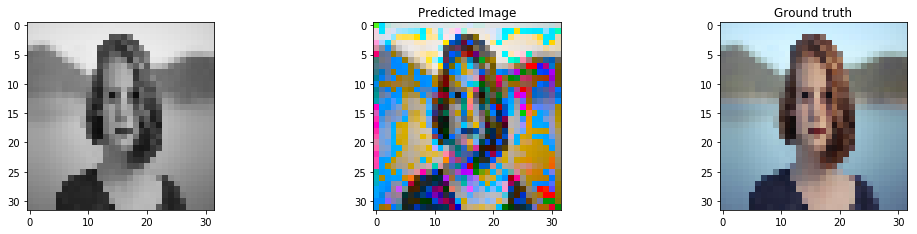

In [94]:
ImagePath = "../input/testimage/1.jpg"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

PSNR :  10.800582
SSIM :  0.9951576


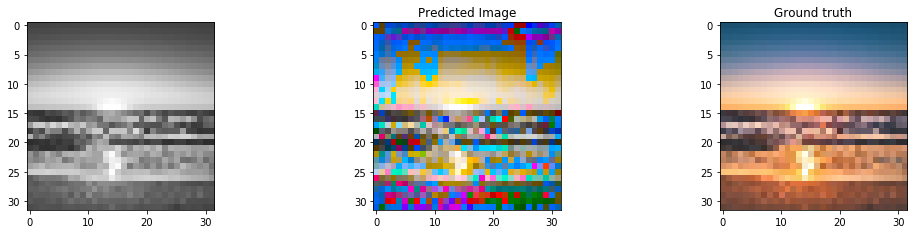

In [95]:
ImagePath = "../input/testimage/2.jpeg"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

PSNR :  11.562126
SSIM :  1.0003587


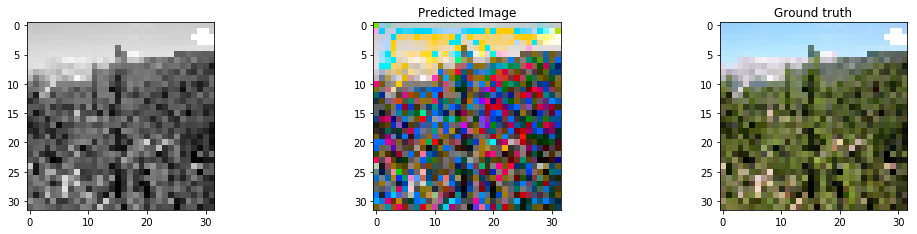

In [96]:
ImagePath = "../input/testimage/3.jpg"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

PSNR :  13.374235
SSIM :  0.99197024


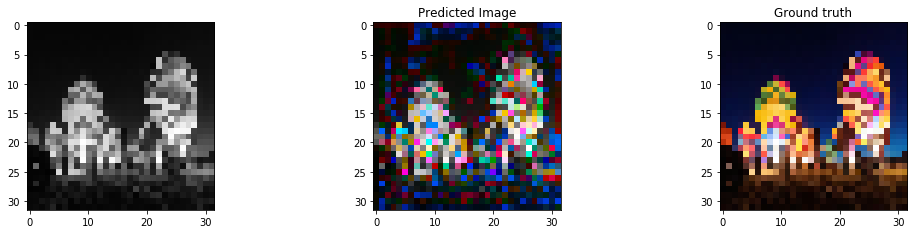

In [97]:
ImagePath = "../input/testimage/4.jpg"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

**CONCLUSION**
* **The Model is able to identify the correct pattern or shades in which the color must be filled or we can say the model is able to separate out the portions which is needed to be colored  to get the colorized image but is not able to predict the accurate color for that shade or portion all the time with respect to the ground truth image.**
* **I hope With the Help of feature extraction with ResNet this problem could be solved easily.**
* **The Resuls also reflects the actual requirement for GAN and other image colorization techniques.**

PSNR :  11.1256695
SSIM :  0.9972332


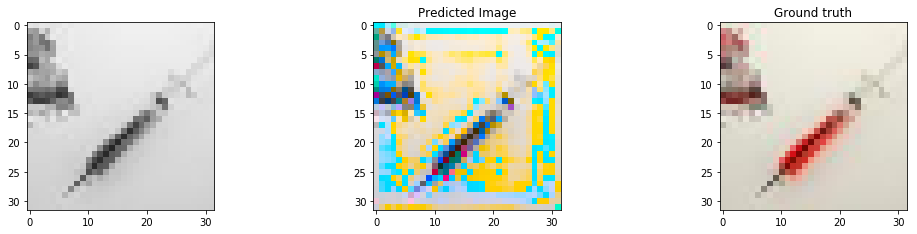

In [98]:
ImagePath = "../input/tiny-imagenet/tiny-imagenet-200/test/images/test_100.JPEG"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

PSNR :  11.102425
SSIM :  0.9970536


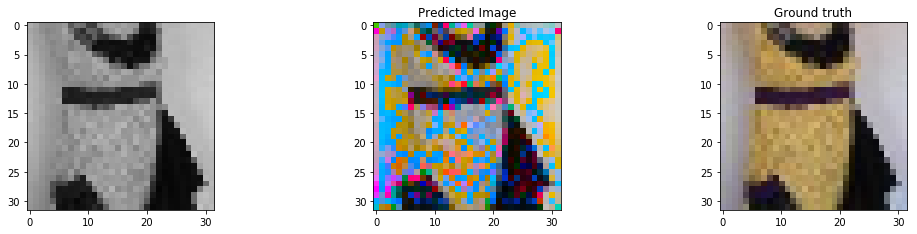

In [99]:
ImagePath = "../input/tiny-imagenet/tiny-imagenet-200/test/images/test_520.JPEG"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)

PSNR :  12.822889
SSIM :  0.9849222


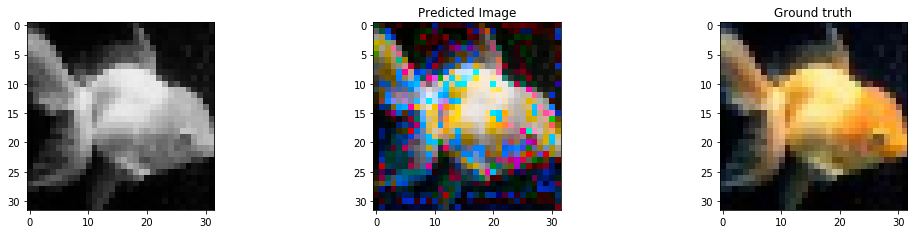

In [100]:

ImagePath = "../input/tiny-imagenet/tiny-imagenet-200/train/n01443537/images/n01443537_5.JPEG"

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*WIDTH
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(WIDTH,HEIGHT,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)

plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
img_1 = cv2.resize(img_1, (WIDTH, HEIGHT))
plt.imshow(img_1)

# img_ is predicted, img_1 is ground truth
psnr_score = psnr(img_, img_1)
print("PSNR : ", psnr_score)

# img_ is predicted, img_1 is ground truth
cv2.imwrite("predicted.JPEG", img_)
cv2.imwrite("groundtruth.JPEG", img_1)
img1 = np.asarray(cv2.imread("predicted.JPEG", 0))
img2 = np.asarray(cv2.imread("groundtruth.JPEG", 0))
ssim_score = ssim(img1,img2)
print("SSIM : ",ssim_score)